In [12]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_absolute_error
import matplotlib.pyplot as plt
import os
from sklearn.inspection import permutation_importance

cwd = os.getcwd()

file_name = "//ukpn-smart-meter-consumption-substation.csv"

file_path = cwd + file_name

# read into pandas 

csv_read = pd.read_csv(file_path)

df = pd.DataFrame(csv_read)

desired_cols = [
    "data_collection_log_timestamp",
    "secondary_substation_id",
    "total_consumption_active_import"
]

Computation of each cluster to group substations 

/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_27455/4231597910.py:11: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('30T')['total_consumption_active_import']


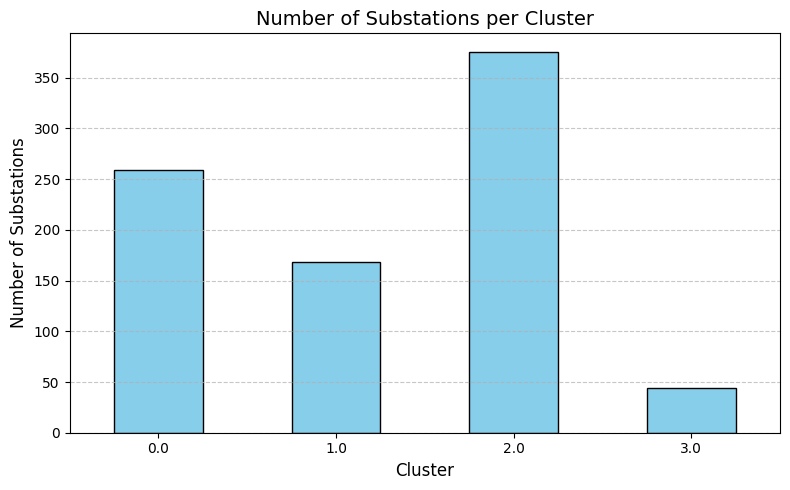

      secondary_substation_id data_collection_log_timestamp  \
0  EPN-R00000000A01C-000-023Z     2024-06-01 01:00:00+01:00   
1  EPN-R00000000A01C-000-023Z     2024-06-01 01:30:00+01:00   
2  EPN-R00000000A01C-000-023Z     2024-06-01 02:00:00+01:00   
3  EPN-R00000000A01C-000-023Z     2024-06-01 02:30:00+01:00   
4  EPN-R00000000A01C-000-023Z     2024-06-01 03:00:00+01:00   

   total_consumption_active_import  half_hour_slot  cluster  
0                            738.0               2      2.0  
1                            647.0               3      2.0  
2                           1992.0               4      2.0  
3                           2119.0               5      2.0  
4                           2162.0               6      2.0  


In [13]:
df = df.reset_index()
df = df[desired_cols].copy()
df['data_collection_log_timestamp'] = pd.to_datetime(
    df['data_collection_log_timestamp'], errors='coerce'
)
df = df.dropna(subset=['data_collection_log_timestamp'])
df = df.set_index('data_collection_log_timestamp')

df_half_hourly = (  
    df.groupby('secondary_substation_id')
      .resample('30T')['total_consumption_active_import']
      .mean()
      .reset_index()
)

# Extract time-of-day slot
df_half_hourly['half_hour_slot'] = (
    df_half_hourly['data_collection_log_timestamp'].dt.hour * 2 +
    df_half_hourly['data_collection_log_timestamp'].dt.minute // 30
)

# Average across all days for each substation
daily_profiles = (
    df_half_hourly.groupby(['secondary_substation_id', 'half_hour_slot'])['total_consumption_active_import']
    .mean()
    .unstack(fill_value=0)  # 48 columns for 48 slots
)
daily_profiles = daily_profiles.dropna()
breakpoint
scaler = StandardScaler()
profiles_scaled = scaler.fit_transform(daily_profiles)

kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(profiles_scaled)

# Add labels back to profiles
daily_profiles['cluster'] = cluster_labels

df_clusters = df_half_hourly.merge(
    daily_profiles[['cluster']],
    left_on='secondary_substation_id',
    right_index=True,
    how='left'
)

substation_counts = df_clusters.groupby('cluster')['secondary_substation_id'].nunique()

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
substation_counts.sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Substations per Cluster', fontsize=14)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Substations', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(df_clusters.head())

Introduction of RF model 

In [14]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, d2_absolute_error_score
import numpy as np

cluster_0 = df_clusters[df_clusters['cluster'] == 0]
cluster_1 = df_clusters[df_clusters['cluster'] == 1]
cluster_2 = df_clusters[df_clusters['cluster'] == 2]
cluster_3 = df_clusters[df_clusters['cluster'] == 3]

half_hourly_prices = "Temp_Prices"
cwd = os.getcwd()
df_halfs = pd.read_csv(cwd + '//' + half_hourly_prices)
df_halfs['Datetime'] = pd.to_datetime(df_halfs['Datetime'])
# df_half_hourly= df_hourly.reset_index()


import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# --- Merge function ---
def merge_df(df_clusters, df_half):
    df_clusters = df_clusters.copy()  # avoid SettingWithCopyWarning
    df_clusters.loc[:, 'timestamp'] = pd.to_datetime(
        df_clusters['data_collection_log_timestamp']
    ).dt.tz_convert(None)

    df_hourly_prices = df_half.copy()
    df_hourly_prices.rename(columns={'Datetime': 'timestamp', 'Price': 'price'}, inplace=True)
    df_hourly_prices['timestamp'] = pd.to_datetime(df_hourly_prices['timestamp'])

    df_clustered_prices = pd.merge(
        df_clusters,
        df_hourly_prices[['timestamp', 'price']],
        on='timestamp',
        how='inner'
    )

    df_clustered_prices = df_clustered_prices.dropna(
        subset=['price', 'total_consumption_active_import']
    )

    return df_clustered_prices

# --- Model function ---
def rand_for_reg(df):
    df = df.copy()
    df['half_hour_slot'] = df['timestamp'].dt.hour * 2 + (df['timestamp'].dt.minute // 30)
    df['dayofweek'] = df['timestamp'].dt.dayofweek
    df['is_weekend'] = (df['dayofweek'] >= 5).astype(int)

    features = ['price', 'half_hour_slot', 'dayofweek', 'is_weekend']
    target = 'total_consumption_active_import'

    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    ame = d2_absolute_error_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    metrics = [[rmse], [r2], [ame], [mae]]

    feat_imp = pd.DataFrame({
        'feature': features,
        'importance': model.feature_importances_
    }).sort_values(by='importance', ascending=False)

    return model, metrics, feat_imp

# --- Main loop for all clusters ---
def train_all_clusters(df_clusters, df_halfs):
    results = []
    models = {}

    for cluster_id in sorted(df_clusters['cluster'].unique()):
        cluster_df = df_clusters[df_clusters['cluster'] == cluster_id]
        merged_df = merge_df(cluster_df, df_halfs)

        if merged_df.empty:
            print(f"⚠️ Cluster {cluster_id} has no matching price data, skipping.")
            continue

        model, [[rmse], [r2], [ame], [mae]], features = rand_for_reg(merged_df)
        models[cluster_id] = model
        results.append({
            'cluster': cluster_id,
            'RMSE': rmse,
            'R²': r2,
            'D2': ame,
            'MAE': mae 
        })

    results_df = pd.DataFrame(results).sort_values(by='cluster').reset_index(drop=True)
    return results_df, models

# --- Run ---
results_df, models = train_all_clusters(df_clusters, df_halfs)

print("\n📊 Cluster Model Performance:")
print(results_df)


⚠️ Cluster nan has no matching price data, skipping.

📊 Cluster Model Performance:
   cluster         RMSE        R²        D2          MAE
0      0.0  2761.371293  0.371947  0.216824  2170.061005
1      1.0  3836.491819  0.534665  0.331247  3005.090533
2      2.0  2030.272991  0.103453  0.042422  1608.089650
3      3.0  7755.161756  0.463939  0.301751  5819.211150


Production of Agile Octopus / Substaion / LV Feeder aggregated dataset 

In [15]:
half_hourly_prices = "Temp_Prices"
cwd = os.getcwd()
df_half = pd.read_csv(cwd + '//' + half_hourly_prices)
df_half['Datetime'] = pd.to_datetime(df_half['Datetime'])

# df_half_hourly= df_hourly.reset_index()

df_hourly_prices = df_half

df_hourly_prices.rename(columns={'Datetime': 'timestamp', 'Price': 'price'}, inplace=True)

# refresh data and reimport 

wd = os.getcwd()

file_name = "//ukpn-smart-meter-consumption-substation.csv"

file_path = cwd + file_name

# read into pandas 

csv_read = pd.read_csv(file_path)

df = pd.DataFrame(csv_read)

# Ensure datetime is parsed properly
df['data_collection_log_timestamp'] = pd.to_datetime(df['data_collection_log_timestamp'], errors='coerce')

# Keep relevant columns
df = df[['data_collection_log_timestamp', 'total_consumption_active_import']]

# Drop rows with NaT timestamps
df = df.dropna(subset=['data_collection_log_timestamp'])

# Set timestamp as index
df = df.set_index('data_collection_log_timestamp')

# Resample to 30-minute intervals and take the mean or sum
df_half_hourly = df.resample('30T').mean().dropna()  # or .mean() if you prefer

df_half_hourly = df_half_hourly.reset_index()


df_half_hourly['timestamp'] = pd.to_datetime(df_half_hourly['data_collection_log_timestamp'])
# Substation data
df_half_hourly['timestamp'] = pd.to_datetime(df_half_hourly['data_collection_log_timestamp']).dt.tz_localize(None)

df_merged = pd.merge(df_half_hourly, df_hourly_prices, on='timestamp', how='inner')

output = rand_for_reg(df_merged)
model1 = output[0]
metrics = output[1]

/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_27455/1250639812.py:38: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_half_hourly = df.resample('30T').mean().dropna()  # or .mean() if you prefer


Feature importance for pooled model 

In [16]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

def prepare_df_long(df_clusters: pd.DataFrame, df_prices: pd.DataFrame) -> pd.DataFrame:
    
    dfc = df_clusters.copy()
    dfc['timestamp'] = pd.to_datetime(dfc['data_collection_log_timestamp']).dt.tz_convert(None)
    dfc = dfc.rename(columns={'total_consumption_active_import': 'consumption'})

    dfp = df_prices.copy()
    rename_map = {}
    if 'Datetimne' in dfp.columns:  # typo guard
        rename_map['Datetimne'] = 'timestamp'
    if 'Price' in dfp.columns:
        rename_map['Price'] = 'price'
    if rename_map:
        dfp = dfp.rename(columns=rename_map)

    # Ensure timestamp is datetime
    dfp['timestamp'] = pd.to_datetime(dfp['timestamp'])

    # Inner join on timestamp
    df_long = pd.merge(
        dfc[['timestamp', 'cluster', 'consumption']],
        dfp[['timestamp', 'price']],
        on='timestamp',
        how='inner'
    ).sort_values(['cluster', 'timestamp'])

    # Drop nulls and reset index
    df_long = df_long.dropna(subset=['consumption', 'price', 'timestamp']).reset_index(drop=True)
    return df_long


def add_time_features(df: pd.DataFrame, ts_col: str = 'timestamp', half_hour: bool = True):
    
    d = df.copy()
    d[ts_col] = pd.to_datetime(d[ts_col])

    time_cols = []
    if half_hour:
        d['half_hour_slot'] = d[ts_col].dt.hour * 2 + (d[ts_col].dt.minute // 30)
        time_cols.append('half_hour_slot')
    else:
        d['hour'] = d[ts_col].dt.hour
        time_cols.append('hour')

    d['dayofweek'] = d[ts_col].dt.dayofweek
    d['is_weekend'] = (d['dayofweek'] >= 5).astype(int)
    feature_cols = ['price'] + time_cols + ['dayofweek', 'is_weekend']
    return d, feature_cols


def compute_feature_importance(df_clusters: pd.DataFrame,
                               df_prices: pd.DataFrame,
                               model=None,
                               target_col: str = 'consumption',
                               ts_col: str = 'timestamp',
                               half_hour: bool = True) -> pd.DataFrame:

    df_long = prepare_df_long(df_clusters, df_prices)
    df_feat, feature_cols = add_time_features(df_long, ts_col=ts_col, half_hour=half_hour)

    X = df_feat[feature_cols]
    y = df_feat[target_col].astype(float)

    # Fit default model if none provided
    fitted = model
    if fitted is None:
        fitted = RandomForestRegressor(
            n_estimators=400,
            random_state=42,
            n_jobs=-1,
            max_depth=None,
            min_samples_leaf=1
        )
        fitted.fit(X, y)
    else:
        # If you pass a pre-trained model, ensure it has feature_importances_
        if not hasattr(fitted, "feature_importances_"):
            raise ValueError("Provided model does not expose .feature_importances_")

    importances = getattr(fitted, "feature_importances_")
    fi = (
        pd.DataFrame({'feature': feature_cols, 'importance': importances})
        .sort_values('importance', ascending=False)
        .reset_index(drop=True)
    )
    return fi

df_clustered = merge_df(df_clusters, df_hourly_prices)
fi = compute_feature_importance(df_clustered, df_hourly_prices, model=model1)
print(fi)


          feature  importance
0  half_hour_slot    0.910270
1       dayofweek    0.042796
2      is_weekend    0.026443
3           price    0.020492


Testing of Reformed Dynamic Tariffs 

In [22]:

from __future__ import annotations
import numpy as np
import pandas as pd
from typing import Tuple, Dict, Optional

# Statsmodels for OLS (average elasticity)
import statsmodels.formula.api as smf

# Scikit-learn for S-learner (heterogeneous effects)
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit


# Shared helpers / preprocessing

def add_time_features(df: pd.DataFrame) -> pd.DataFrame:
    # Add time features used across methods
    df = df.copy()
    if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
        df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["half_hour_slot"] = df["timestamp"].dt.hour * 2 + (df["timestamp"].dt.minute // 30)
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    return df

def make_price_scenario(
    df: pd.DataFrame,
    peak_hours: Tuple[int, int] = (16, 20),   # inclusive start hour, exclusive end hour
    peak_mult: float = 2.5,
    offpeak_mult: float = 0.6,
    revenue_neutral: Optional[str] = "day"    # None, "day", or "all"
) -> pd.Series:
    
    # Create a reformed price series by multiplying peak & off-peak.
    # Optional revenue neutrality: scale prices so total spend is unchanged per 'day' or 'all'.
    # Returns a pd.Series aligned to df.index named 'price_new'.
    
    df_ = add_time_features(df)
    hh = df_["half_hour_slot"]
    peak_mask = (hh >= peak_hours[0]*2) & (hh < peak_hours[1]*2)
    price_new = df_["price"] * np.where(peak_mask, peak_mult, offpeak_mult)
    price_new = pd.Series(price_new.values, index=df.index, name="price_new")

    if revenue_neutral is None:
        return price_new

    if revenue_neutral == "all":
        denom = price_new.sum()
        scale = (df["price"].sum() / denom) if denom > 0 else 1.0
        return (price_new * scale).rename("price_new")

    if revenue_neutral == "day":
        df_tmp = df.copy()
        df_tmp["price_new"] = price_new.values
        def _renorm(g):
            denom = g["price_new"].sum()
            s = g["price"].sum() / denom if denom > 0 else 1.0
            g["price_new"] *= s
            return g
        out = (df_tmp
               .assign(date=df_tmp["timestamp"].dt.date)
               .groupby("date", group_keys=False)
               .apply(_renorm))
        return out["price_new"]

    raise ValueError("revenue_neutral must be one of {None, 'day', 'all'}")

# ----------------------------
# (1) Average elasticity (log–log OLS with fixed effects)
# ----------------------------

def average_elasticity_loglog(df: pd.DataFrame):
    
    # Fit: ln(C) ~ ln(P) + FE(half_hour_slot) + FE(dayofweek)
    # Returns (beta, model), where beta is the average price elasticity
    
    df_ = add_time_features(df).copy()
    df_["lnC"] = np.log(df_["total_consumption_active_import"].clip(lower=1e-6))
    df_["lnP"] = np.log(df_["price"].clip(lower=1e-6))

    model = smf.ols("lnC ~ lnP + C(half_hour_slot) + C(dayofweek)", data=df_).fit(cov_type="HC1")
    beta = float(model.params["lnP"])
    return beta, model

def simulate_with_average_elasticity(
    df: pd.DataFrame,
    price_new: pd.Series,
    beta: float
) -> pd.Series:
    
    # Counterfactual using average elasticity beta:
    #   C_new = C_base * (P_new / P_base) ** beta
    
    P_base = df["price"].clip(lower=1e-6).values
    P_new = pd.Series(price_new, index=df.index).clip(lower=1e-6).values
    C_base = df["total_consumption_active_import"].values
    C_new = C_base * (P_new / P_base) ** beta
    return pd.Series(C_new, index=df.index, name="C_new_avg")

# ----------------------------
# (2) Anchored S-learner (cross-fitted) + counterfactuals
# ----------------------------

def _fit_hgbr():
    
    return HistGradientBoostingRegressor(
        loss="squared_error",
        max_depth=None,
        learning_rate=0.05,
        max_iter=400,
        random_state=0
    )

def simulate_with_slearner_anchored(
    df: pd.DataFrame,
    price_new: pd.Series,
    n_splits: int = 5,
    clip_quantiles: tuple[float, float] = (0.05, 0.95),
) -> tuple[pd.Series, pd.Series]:
    
    # Cross-fitted S-learner *anchored* predictions:
    #   - Train on each fold's train split once.
    #   - On the test split, predict lnC twice with the same model:
    #       (a) lnP = observed (baseline prediction)
    #       (b) lnP = ln(price_new) (counterfactual prediction, clipped to train range)
    
    df_ = add_time_features(df).copy()
    df_["lnC"] = np.log(df_["total_consumption_active_import"].clip(lower=1e-9))
    df_["lnP"] = np.log(df_["price"].clip(lower=1e-12))

    price_new = pd.Series(price_new, index=df.index)
    lnP_new_full = np.log(price_new.clip(lower=1e-12))

    feats = ["lnP", "half_hour_slot", "dayofweek", "is_weekend"]
    X = df_[feats]
    y = df_["lnC"]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    lnC_base_all = pd.Series(index=df.index, dtype=float)
    lnC_new_all  = pd.Series(index=df.index, dtype=float)

    for tr_idx, te_idx in tscv.split(X):
        X_tr, X_te = X.iloc[tr_idx].copy(), X.iloc[te_idx].copy()
        y_tr = y.iloc[tr_idx]

        # train once
        model = _fit_hgbr()
        model.fit(X_tr, y_tr)

        # baseline prediction (observed lnP)
        lnC_base = model.predict(X_te)

        # counterfactual prediction (lnP replaced, clipped to train range)
        lnP_lo, lnP_hi = X_tr["lnP"].quantile(clip_quantiles[0]), X_tr["lnP"].quantile(clip_quantiles[1])
        lnP_new_te = lnP_new_full.iloc[te_idx].clip(lower=lnP_lo, upper=lnP_hi)

        X_cf = X_te.copy()
        X_cf["lnP"] = lnP_new_te.values
        lnC_new = model.predict(X_cf)

        lnC_base_all.iloc[te_idx] = lnC_base
        lnC_new_all.iloc[te_idx]  = lnC_new

    C_base_pred = np.exp(lnC_base_all.clip(upper=30))
    C_new_pred  = np.exp(lnC_new_all.clip(upper=30))
    return (
        pd.Series(C_base_pred.values, index=df.index, name="C_base_pred"),
        pd.Series(C_new_pred.values,  index=df.index, name="C_new_pred"),
    )


# KPI helpers

def kpis_from_actual(df: pd.DataFrame, C_new: pd.Series) -> Dict[str, float]:
    
    # KPIs comparing observed consumption C_base vs C_new (used for OLS path)
    
    base = df["total_consumption_active_import"].astype(float)
    new = pd.Series(C_new, index=df.index).astype(float)

    total_reduction_pct = 100 * (1 - new.sum() / base.sum())
    peak_base = base.max(); peak_new = new.max()
    avg_base = base.mean(); avg_new = new.mean()
    lf_base = avg_base / peak_base if peak_base > 0 else np.nan
    lf_new  = avg_new  / peak_new  if peak_new  > 0 else np.nan

    return {
        "total_reduction_pct": float(total_reduction_pct),
        "peak_reduction": float(peak_base - peak_new),
        "load_factor_change": float(lf_new - lf_base)
    }

def kpis_from_preds(C_base_pred: pd.Series, C_new_pred: pd.Series) -> Dict[str, float]:
    """
    KPIs comparing baseline-predicted vs counterfactual-predicted (used for S-learner path).
    Baseline scenario (price_new == price) will give ≈0% change.
    """
    base = pd.Series(C_base_pred).astype(float)
    new  = pd.Series(C_new_pred).astype(float)

    total_reduction_pct = 100 * (1 - new.sum() / base.sum())
    peak_base = base.max(); peak_new = new.max()
    avg_base = base.mean(); avg_new = new.mean()
    lf_base = avg_base / peak_base if peak_base > 0 else np.nan
    lf_new  = avg_new  / peak_new  if peak_new  > 0 else np.nan

    return {
        "total_reduction_pct": float(total_reduction_pct),
        "peak_reduction": float(peak_base - peak_new),
        "load_factor_change": float(lf_new - lf_base)
    }


# Scenario runner

def run_tariff_scenarios(
    df: pd.DataFrame,
    scenarios: Dict[str, Dict],
    peak_hours: Tuple[int, int] = (16, 20)  # default if scenario doesn't specify
) -> Dict[str, pd.DataFrame]:
    # estimate beta 
    avg_rows, slearn_rows = [], []

    for name, params in scenarios.items():
        # pick per-scenario peak window, falling back to function default
        sc_peak_hours = params.get("peak_hours", peak_hours)

        if name.lower() == "baseline":
            price_new = df["price"].rename("price_new")
        else:
            price_new = make_price_scenario(
                df,
                peak_hours=sc_peak_hours,                      # <-- key change
                peak_mult=params.get("peak_mult", 1.0),
                offpeak_mult=params.get("offpeak_mult", 1.0),
                revenue_neutral="day"
            )

        # ...then your existing OLS + S-learner code and KPI logging

        # --- Method 1: Average elasticity ---
        C_new_avg = simulate_with_average_elasticity(df, price_new, beta)
        avg_k = kpis_from_actual(df, C_new_avg)
        avg_rows.append({"scenario": name, **avg_k, "beta_avg_elasticity": beta})

        # --- Method 2: Anchored S-learner ---
        C_base_pred, C_new_pred = simulate_with_slearner_anchored(
            df, price_new, n_splits=5, clip_quantiles=(0.05, 0.95)
        )
        sl_k = kpis_from_preds(C_base_pred, C_new_pred)
        slearn_rows.append({"scenario": name, **sl_k})

    avg_tbl = pd.DataFrame(avg_rows).set_index("scenario")
    sl_tbl = pd.DataFrame(slearn_rows).set_index("scenario")

    return {"average_elasticity": avg_tbl, "s_learner": sl_tbl}

# run code 
if __name__ == "__main__":

    scenarios = {
    # Baseline
    "Baseline": {"peak_hours": None, "peak_mult": 1.0, "offpeak_mult": 1.0},

    # Moderate reforms (8)
    "Moderate_17-20_pm1.5_om0.9":  {"peak_hours": (17,20), "peak_mult": 1.5, "offpeak_mult": 0.9},
    "Moderate_17-20_pm2.0_om0.9":  {"peak_hours": (17,20), "peak_mult": 2.0, "offpeak_mult": 0.9},
    "Moderate_18-21_pm1.5_om0.75": {"peak_hours": (18,21), "peak_mult": 1.5, "offpeak_mult": 0.75},
    "Moderate_18-21_pm2.0_om0.75": {"peak_hours": (18,21), "peak_mult": 2.0, "offpeak_mult": 0.75},
    "Moderate_17-21_pm1.5_om0.9":  {"peak_hours": (17,21), "peak_mult": 1.5, "offpeak_mult": 0.9},
    "Moderate_16-19_pm1.5_om0.9":  {"peak_hours": (16,19), "peak_mult": 1.5, "offpeak_mult": 0.9},
    "Moderate_16-19_pm2.0_om0.75": {"peak_hours": (16,19), "peak_mult": 2.0, "offpeak_mult": 0.75},
    "Moderate_17-20_pm2.0_om0.75": {"peak_hours": (17,20), "peak_mult": 2.0, "offpeak_mult": 0.75},

    # Aggressive reforms (8)
    "Aggressive_17-20_pm2.5_om0.6": {"peak_hours": (17,20), "peak_mult": 2.5, "offpeak_mult": 0.6},
    "Aggressive_17-20_pm3.0_om0.6": {"peak_hours": (17,20), "peak_mult": 3.0, "offpeak_mult": 0.6},
    "Aggressive_18-21_pm2.5_om0.6": {"peak_hours": (18,21), "peak_mult": 2.5, "offpeak_mult": 0.6},
    "Aggressive_18-21_pm3.0_om0.6": {"peak_hours": (18,21), "peak_mult": 3.0, "offpeak_mult": 0.6},
    "Aggressive_17-21_pm2.5_om0.75": {"peak_hours": (17,21), "peak_mult": 2.5, "offpeak_mult": 0.75},
    "Aggressive_17-21_pm3.0_om0.6":  {"peak_hours": (17,21), "peak_mult": 3.0, "offpeak_mult": 0.6},
    "Aggressive_16-19_pm2.5_om0.75": {"peak_hours": (16,19), "peak_mult": 2.5, "offpeak_mult": 0.75},
    "Aggressive_16-19_pm3.0_om0.6":  {"peak_hours": (16,19), "peak_mult": 3.0, "offpeak_mult": 0.6},

    # Special cases (3)
    "Special_LongPeak_16-21_pm2.0_om0.75": {"peak_hours": (16,21), "peak_mult": 2.0, "offpeak_mult": 0.75},
    "Special_EVfriendly_00-07_om0.6_17-20_pm2.0": {"peak_hours": (17,20), "peak_mult": 2.0, "offpeak_mult": 0.6},  
}


    results = run_tariff_scenarios(df_clustered, scenarios, peak_hours=(17, 20))

    print("\n=== Average Elasticity Method ===")
    print(results["average_elasticity"].round(4))

    print("\n=== Anchored S-Learner Method ===")
    print(results["s_learner"].round(4))

    combined = (results["average_elasticity"]
                .add_prefix("AvgElasticity_")
                .join(results["s_learner"].add_prefix("SLearner_"), how="outer"))
    print("\n=== Combined KPI Table ===")
    print(combined.round(4))


/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_27455/3828935994.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_renorm))
/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_27455/3828935994.py:72: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(_renorm))
/var/folders/y5/gpdc5fcj7yn14_gxnjxr8qkw0000gn/T/ipykernel_27455/3828935994.py:72: DeprecationWarning: DataFrameGroupB


=== Average Elasticity Method ===
                                            total_reduction_pct  \
scenario                                                          
Baseline                                                 0.0000   
Moderate_17-20_pm1.5_om0.9                              -0.0148   
Moderate_17-20_pm2.0_om0.9                              -0.0313   
Moderate_18-21_pm1.5_om0.75                             -0.0205   
Moderate_18-21_pm2.0_om0.75                             -0.0390   
Moderate_17-21_pm1.5_om0.9                              -0.0162   
Moderate_16-19_pm1.5_om0.9                              -0.0171   
Moderate_16-19_pm2.0_om0.75                             -0.0501   
Moderate_17-20_pm2.0_om0.75                             -0.0453   
Aggressive_17-20_pm2.5_om0.6                            -0.0915   
Aggressive_17-20_pm3.0_om0.6                            -0.1154   
Aggressive_18-21_pm2.5_om0.6                            -0.0815   
Aggressive_18-21_pm3.0_om0.

Plotting for dynamic reform 

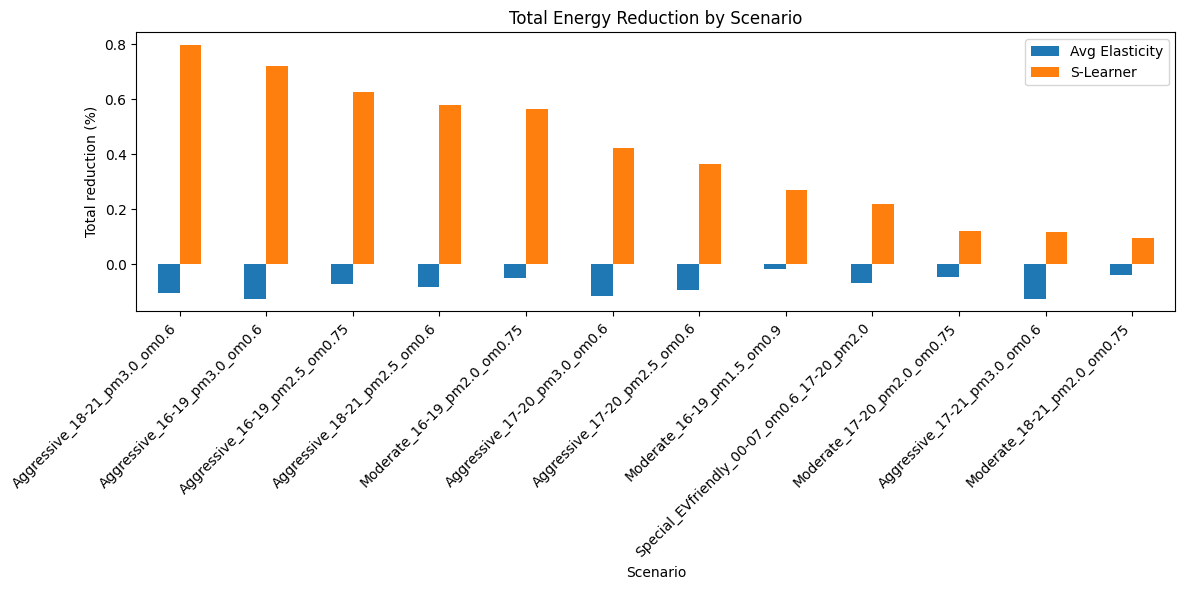

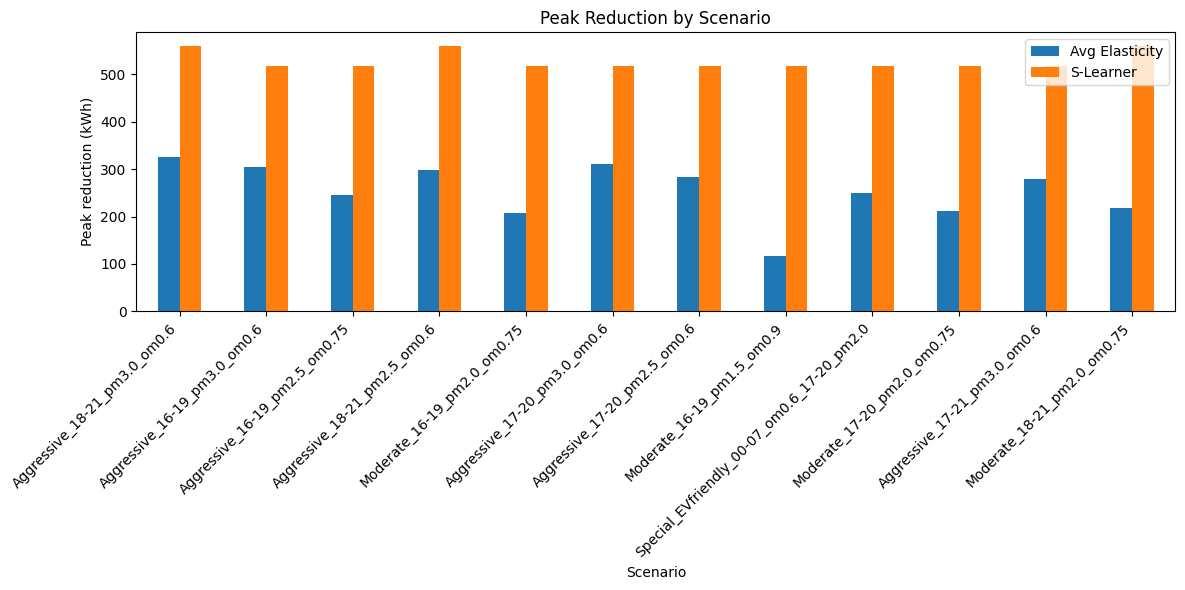

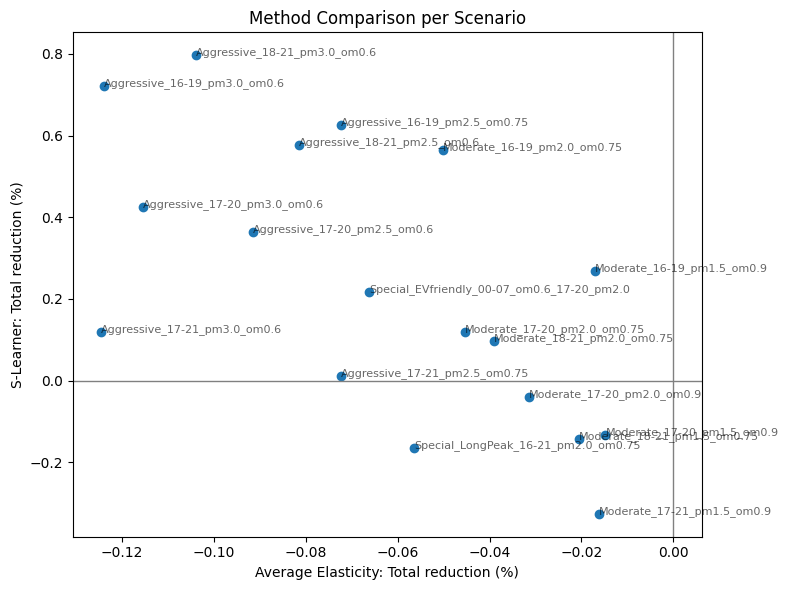

In [20]:
N = 12
df = combined.drop(index="Baseline", errors="ignore").copy()
df = df.sort_values("SLearner_total_reduction_pct", ascending=False).head(N)

# build plotting frame 
plot_df = pd.DataFrame({
    "Avg Elasticity": df["AvgElasticity_total_reduction_pct"],
    "S-Learner":      df["SLearner_total_reduction_pct"]
})
ax = plot_df.plot(kind="bar", figsize=(12,6))
ax.set_ylabel("Total reduction (%)")
ax.set_xlabel("Scenario")
ax.set_title("Total Energy Reduction by Scenario")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

plot_df = pd.DataFrame({
    "Avg Elasticity": df["AvgElasticity_peak_reduction"],
    "S-Learner":      df["SLearner_peak_reduction"]
})
ax = plot_df.plot(kind="bar", figsize=(12,6))
ax.set_ylabel("Peak reduction (kWh)")
ax.set_xlabel("Scenario")
ax.set_title("Peak Reduction by Scenario")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

df_sc = combined.drop(index="Baseline", errors="ignore").copy()
plt.figure(figsize=(8,6))
plt.scatter(df_sc["AvgElasticity_total_reduction_pct"], df_sc["SLearner_total_reduction_pct"])
for name, row in df_sc.iterrows():
    plt.annotate(name, (row["AvgElasticity_total_reduction_pct"], row["SLearner_total_reduction_pct"]),
                 fontsize=8, alpha=0.6)
plt.axvline(0, color="gray", linewidth=1)
plt.axhline(0, color="gray", linewidth=1)
plt.xlabel("Average Elasticity: Total reduction (%)")
plt.ylabel("S-Learner: Total reduction (%)")
plt.title("Method Comparison per Scenario")
plt.tight_layout()
plt.show()


Static reform 

In [21]:
import numpy as np
import pandas as pd

# Build a fixed (flat) tariff series 
def make_fixed_tariff_prices(
    df_clustered: pd.DataFrame,
    mode: str = "day_mean",   # "day_mean", "overall_mean", or "value"
    value: float | None = None
) -> pd.Series:
    
    # Returns a flat price series 'price_new' aligned to df_clustered.index

    df = df_clustered.copy()
    if not np.issubdtype(df["timestamp"].dtype, np.datetime64):
        df["timestamp"] = pd.to_datetime(df["timestamp"])

    if mode == "day_mean":
        day_mean = (df.assign(date=df["timestamp"].dt.date)
                      .groupby("date")["price"].transform("mean"))
        return pd.Series(day_mean.values, index=df.index, name="price_new")

    if mode == "overall_mean":
        flat = float(df["price"].mean())
        return pd.Series(flat, index=df.index, name="price_new")

    if mode == "value":
        if value is None:
            raise ValueError("Provide `value` when mode='value'.")
        return pd.Series(float(value), index=df.index, name="price_new")

    raise ValueError("mode must be one of {'day_mean','overall_mean','value'}")


# Apply OLS elasticity to compute counterfactual consumption
def simulate_fixed_tariff_with_beta(
    df_clustered: pd.DataFrame,
    price_new: pd.Series,
    beta: float
) -> pd.Series:

    # Uses the elasticity formula per interval:
    #     C_new = C_base * (P_new / P_base) ** beta
    
    df = df_clustered
    P_base = df["price"].clip(lower=1e-9).values
    P_new  = pd.Series(price_new, index=df.index).clip(lower=1e-9).values
    C_base = df["total_consumption_active_import"].values

    C_new = C_base * (P_new / P_base) ** beta
    return pd.Series(C_new, index=df.index, name="C_new_beta")


# KPI calculator (actual vs counterfactual)
def kpis_from_actual(df_clustered: pd.DataFrame, C_new: pd.Series) -> dict:

    # Compares observed consumption vs. counterfactual:
    
    base = df_clustered["total_consumption_active_import"].astype(float)
    new  = pd.Series(C_new, index=df_clustered.index).astype(float)

    total_reduction_pct = 100.0 * (1.0 - new.sum() / base.sum())
    peak_reduction = float(base.max() - new.max())

    avg_base = base.mean(); peak_base = base.max()
    avg_new  = new.mean();  peak_new  = new.max()
    lf_base = (avg_base / peak_base) if peak_base > 0 else np.nan
    lf_new  = (avg_new  / peak_new ) if peak_new  > 0 else np.nan

    return {
        "total_reduction_pct": float(total_reduction_pct),
        "peak_reduction": peak_reduction,
        "load_factor_change": float(lf_new - lf_base),
    }


def build_flat_scenarios(df_clustered: pd.DataFrame) -> dict:
    """Create a realistic set of flat (no ToU) scenarios with fallback protection."""
    df = df_clustered.copy()
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    overall_mean = float(df["price"].mean())

    # Filters
    is_wknd = df["timestamp"].dt.dayofweek >= 5
    winter  = df["timestamp"].dt.month.isin([12, 1, 2])
    summer  = df["timestamp"].dt.month.isin([6, 7, 8])

    # Safe means (fallback to overall_mean if slice empty)
    wkday_mean  = float(df.loc[~is_wknd, "price"].mean()) if (~is_wknd).any() else overall_mean
    wkend_mean  = float(df.loc[ is_wknd, "price"].mean()) if ( is_wknd).any() else overall_mean
    winter_mean = float(df.loc[winter,   "price"].mean()) if ( winter).any() else overall_mean
    summer_mean = float(df.loc[summer,   "price"].mean()) if ( summer).any() else overall_mean

    scenarios = {
        # Revenue-neutral baselines
        "Flat_day_mean":     {"mode": "day_mean"},
        "Flat_overall_mean": {"mode": "overall_mean"},

        # Policy sensitivity around the overall mean
        "Flat_minus_10pc":   {"mode": "value", "value": 0.90 * overall_mean},
        "Flat_plus_05pc":    {"mode": "value", "value": 1.05 * overall_mean},
        "Flat_plus_10pc":    {"mode": "value", "value": 1.10 * overall_mean},
        "Flat_plus_20pc":    {"mode": "value", "value": 1.20 * overall_mean},
        "Flat_plus_30pc":    {"mode": "value", "value": 1.30 * overall_mean},

        # Robustness variants
        "Flat_wkday_mean":   {"mode": "value", "value": wkday_mean},
        "Flat_wkend_mean":   {"mode": "value", "value": wkend_mean},
        "Flat_winter_mean":  {"mode": "value", "value": winter_mean},
        "Flat_summer_mean":  {"mode": "value", "value": summer_mean},
    }
    return scenarios


def run_flat_tariff_scenarios_to_df(
    df_clustered: pd.DataFrame,
    beta: float,
    csv_path: str = "flat_tariff_results.csv"
) -> pd.DataFrame:
    """
    Runs all flat scenarios using elasticity method and returns a DataFrame of KPIs.
    Also saves the table to CSV for Excel.
    """
    scenarios = build_flat_scenarios(df_clustered)

    rows = []
    for name, cfg in scenarios.items():
        price_new = make_fixed_tariff_prices(
            df_clustered,
            mode=cfg["mode"],
            value=cfg.get("value")
        )
        C_new = simulate_fixed_tariff_with_beta(df_clustered, price_new, beta)
        k = kpis_from_actual(df_clustered, C_new)

        rows.append({
            "scenario": name,
            "mode": cfg["mode"],
            "value": cfg.get("value", np.nan),
            **{f"AvgElasticity_{m}": v for m, v in k.items()}
        })

    flat_results = pd.DataFrame(rows).set_index("scenario").sort_index()
    flat_results.to_csv(csv_path, index=True)
    return flat_results

beta = -0.0036
flat_results = run_flat_tariff_scenarios_to_df(df_clustered, beta, csv_path="flat_tariff_results.csv")
print(flat_results.round(4))


                           mode    value  AvgElasticity_total_reduction_pct  \
scenario                                                                      
Flat_day_mean          day_mean      NaN                             0.1285   
Flat_minus_10pc           value  15.8801                             0.0989   
Flat_overall_mean  overall_mean      NaN                             0.1368   
Flat_plus_05pc            value  18.5268                             0.1543   
Flat_plus_10pc            value  19.4090                             0.1710   
Flat_plus_20pc            value  21.1735                             0.2023   
Flat_plus_30pc            value  22.9380                             0.2310   
Flat_summer_mean          value  17.6446                             0.1368   
Flat_winter_mean          value  17.6446                             0.1368   
Flat_wkday_mean           value  18.6975                             0.1576   
Flat_wkend_mean           value  15.2759            